In [1]:
import torch
from torch.utils.data import Dataset
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import numpy as np
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from unet_model import UNet
from torchinfo import summary
%matplotlib inline

torch.manual_seed(1337)
np.random.seed(1337)

In [2]:
class MyDataset(Dataset):

    def __init__(self, X_path="dataset/x_train.npy", y_path="dataset/y_train.npy"):
        self.X = np.load(X_path).transpose(0, 3, 1, 2)
        self.y = np.load(y_path)
    
    def __len__(self):
        return self.X.shape[0]
    
    def transform(self, image, mask):
        # Random crop
        image = torch.tensor(image)
        mask = torch.tensor(mask)
        i, j, h, w = transforms.RandomCrop.get_params(image, output_size=(256,256))
        image = transforms.functional_tensor.crop(image, i, j, h, w)
        mask = transforms.functional_tensor.crop(mask, i, j, h, w)
    
        # Random horizontal flipping
        if np.random.rand() > 0.5:
            image = transforms.functional_tensor.hflip(image)
            mask = transforms.functional_tensor.hflip(mask)
        
        # Random brightness
        if np.random.rand() > 0.1:
            image = transforms.functional_tensor.adjust_brightness(image, np.random.rand() + 0.5)
        
        # Random Contrast
        if np.random.rand() > 0.1:
            image = transforms.functional_tensor.adjust_contrast(image, np.random.rand() + 0.5)
        
        # Random Gamma
        if np.random.rand() > 0.1:
            image = transforms.functional_tensor.adjust_gamma(image, np.random.rand() + 0.5)
            
        # Random Hue
        if np.random.rand() > 0.1:
            image = transforms.functional_tensor.adjust_hue(image, np.random.rand() - 0.5)
            
        # Random Saturation
        if np.random.rand() > 0.1:
            image = transforms.functional_tensor.adjust_saturation(image, np.random.rand() + 0.5)
            
        return image, mask

    def __getitem__(self, idx):
        return self.transform(self.X[idx], np.expand_dims(self.y[idx], 0))

In [3]:
train_dataset = MyDataset("dataset/x_train.npy", "dataset/y_train.npy")
val_dataset = MyDataset("dataset/x_val.npy", "dataset/y_val.npy")
test_dataset = MyDataset("dataset/x_test.npy", "dataset/y_test.npy")

#hyper params
batch_size = 8


train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

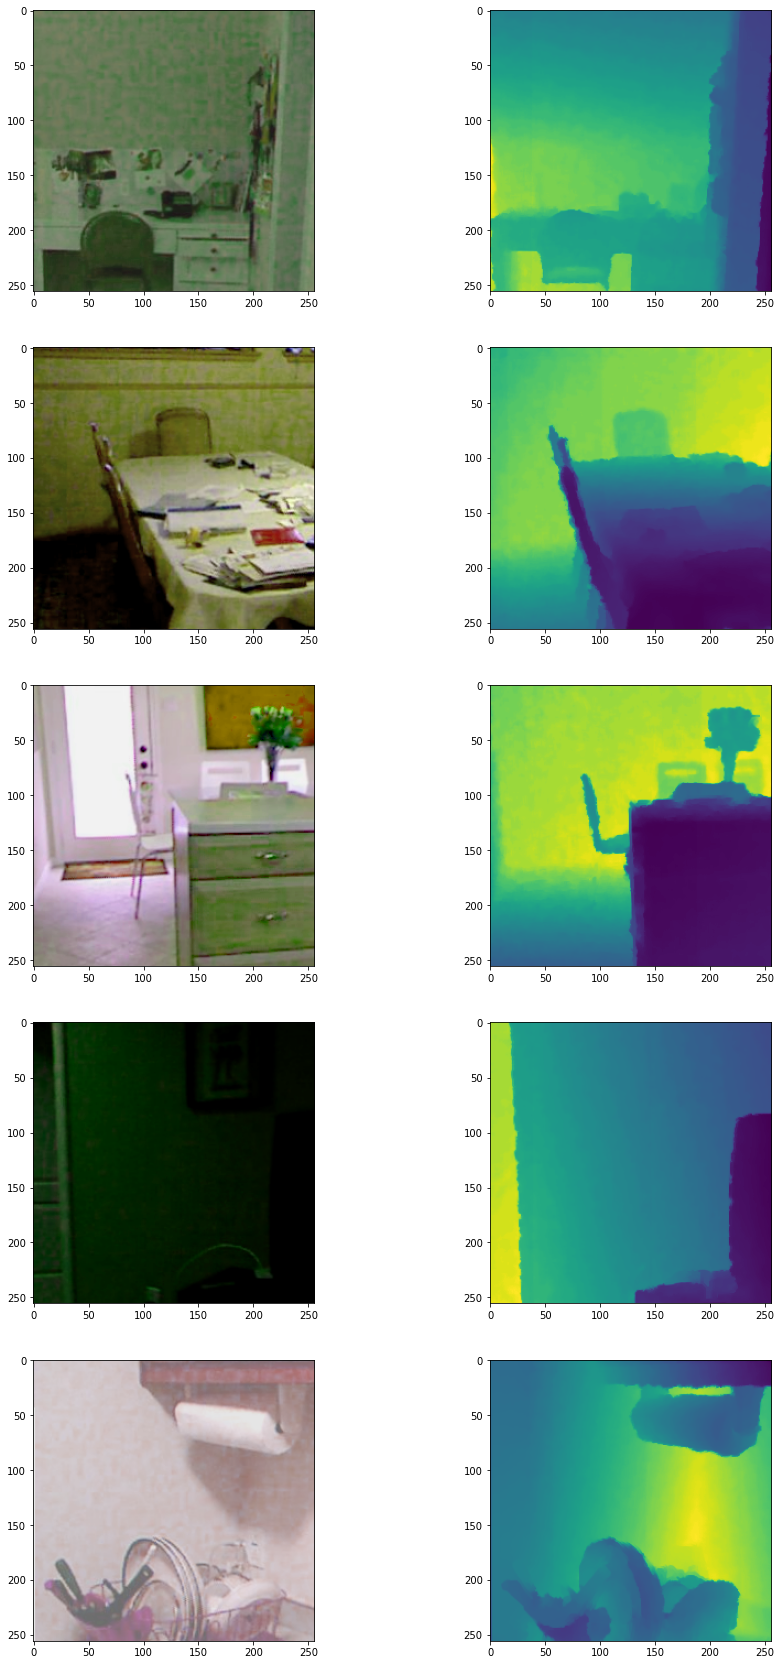

In [4]:
images, ground_truths = [], []

for data, target in train_loader:
    images.append(data.detach().cpu()[0])
    ground_truths.append(target.detach().cpu()[0])
    
fig, axes = plt.subplots(5, 2, figsize=(15, 30))
for i,ax in enumerate(axes):
    image = np.squeeze(images[i])
    ground_truth = np.squeeze(ground_truths[i])
    
    ax[0].imshow(image.permute(1, 2, 0))
    ax[1].imshow(ground_truth)